In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
path='/kaggle/input/cityscapes-image-pairs'
os.listdir(path)

['cityscapes_data']

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision import models
from torchsummary import summary
from tqdm.notebook import tqdm
import cv2

In [3]:
data_dir = os.path.join("/kaggle","input","cityscapes-image-pairs","cityscapes_data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

2975 500


In [4]:
IMAGE_SIZE=[256,256]
IMAGE_SHPAE=IMAGE_SIZE+[3]
def blur(image):
    blurred_image=cv2.GaussianBlur(image,(13,13),0)
    return blurred_image

In [5]:
# File paths
train_filepath_blur = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
#val_filepath_blur = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
def split_image(image):
  image = np.array(image)
  cityscape, label = image[:, :256, :], image[:, 256:, :]
  return cityscape, label
def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 
    mask = np.array(mask)
    
    return image, mask


In [6]:
# Lists to hold data
train_images_blur = []
train_images_clean = []
#val_images_blur = []
#val_images_clean = []
# Assuming you have a predefined image_mask_split function
for train_file in tqdm(os.listdir(train_filepath_blur), desc="Building blurring Dataset:"):
    image, mask = image_mask_split(os.path.join(train_filepath_blur, train_file), IMAGE_SIZE)
    train_image = blur(image)
    train_images_blur.append(train_image)
    train_images_clean.append(image)

# for val_file in tqdm(os.listdir(val_filepath_blur), desc='Building blurring val Dataset:'):
#     image, mask = image_mask_split(os.path.join(val_filepath_blur, val_file), IMAGE_SIZE)
#     val_image = blur(image)
#     val_images_blur.append(val_image)
#     val_images_clean.append(image)

Building blurring Dataset::   0%|          | 0/2975 [00:00<?, ?it/s]

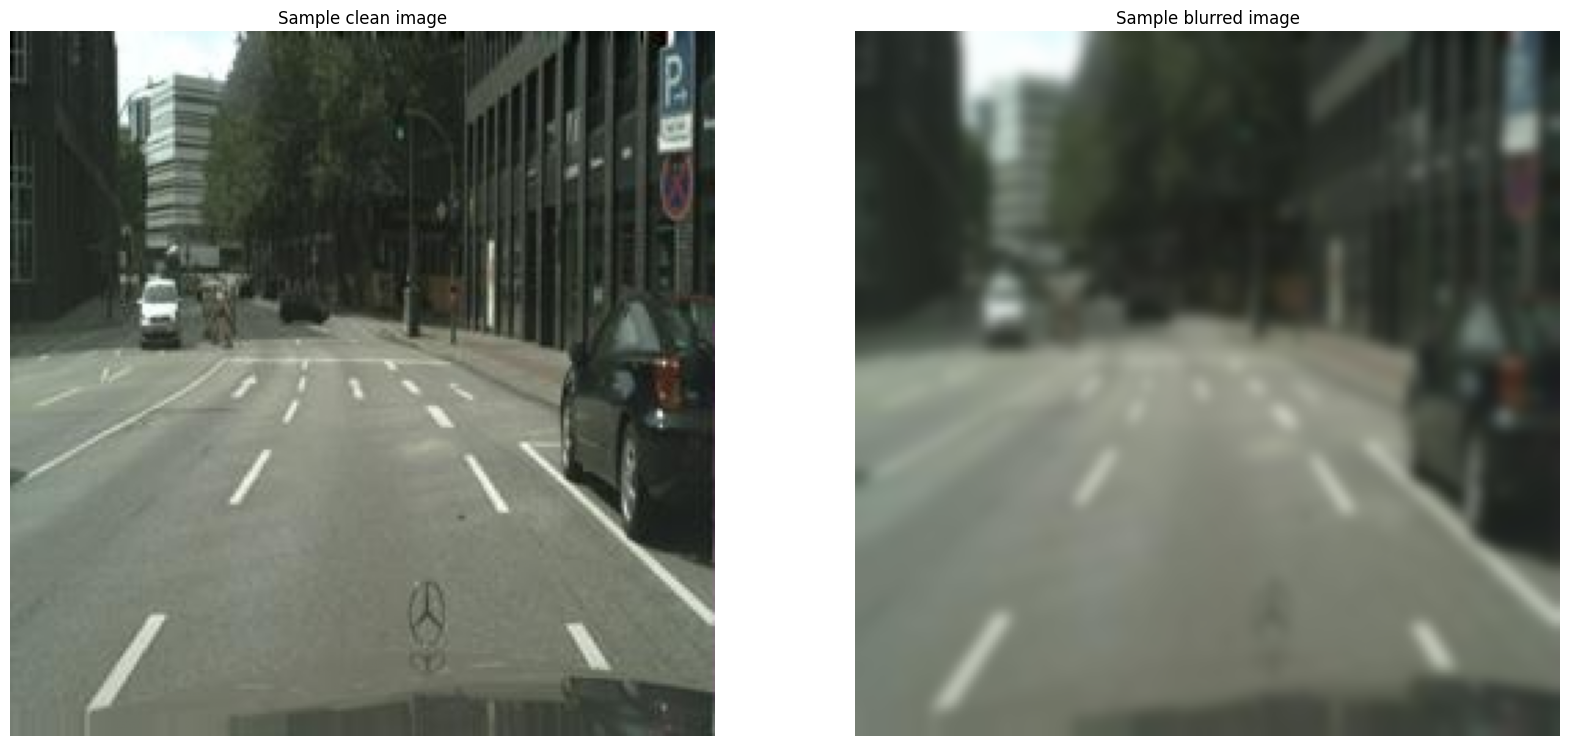

In [7]:
# Visualize samples
plt.figure(figsize=[20, 14])
for i in range(1):
    img = train_images_clean[i]
    blur_img = train_images_blur[i]
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample clean image')

    plt.subplot(1, 2, 2)
    plt.imshow(blur_img)
    plt.axis('off')
    plt.title('Sample blurred image')
plt.show()

In [8]:
# Convert lists to numpy arrays cause thats what u net apparently takes
train_images_blur = np.stack(train_images_blur).astype("float32")
train_images_clean = np.stack(train_images_clean).astype("float32")
# val_images_blur = np.stack(val_images_blur).astype("float32")
# val_images_clean = np.stack(val_images_clean).astype("float32")

In [9]:
class DoubleConvBlur(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlur, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Deblurring(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512]):
        super(Deblurring, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Downsampling part
        for feature in features:
            self.downs.append(DoubleConvBlur(in_channels, feature))
            in_channels = feature

        # Upsampling part
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConvBlur(feature * 2, feature))

        # Bottleneck and final layer
        self.bottleneck = DoubleConvBlur(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [11]:
from torch.utils.data import Dataset


class CustomTrainData(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.blurred_images = [blur(image) for image in images]  # Apply blur once
        self.transform = transform
        print(f"Total valid images: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        blurred_image = self.blurred_images[idx]

        image = torch.tensor(image).permute(2, 0, 1).float()
        blurred_image = torch.tensor(blurred_image).permute(2, 0, 1).float()

        if self.transform:
            image = self.transform(image)
            blurred_image = self.transform(blurred_image)

        return image, blurred_image


In [12]:
# Assuming train_images_clean contains original images
# and you want blurred images to be generated inside the dataset class

train_dataset_blur = CustomTrainData(train_images_clean)
# val_dataset_blur= CustomTrainData(val_images_clean)

train_loader_blur = DataLoader(train_dataset_blur, batch_size=8, shuffle=True)
# val_loader_blur = DataLoader(val_dataset_blur, batch_size=8, shuffle=False)

for image,blurred_img in train_loader_blur:
    print("Train batch-clean image shape:",image.shape)
    print("Train batch-blurred image shape",blurred_img.shape)
    break
# for image,blurred_img in val_loader_blur:
#     print("val batch-clean image shpe:",image.shape)
#     print("val batch-blurred image shape",blurred_img.shape)
#     break

Total valid images: 2975
Train batch-clean image shape: torch.Size([8, 3, 256, 256])
Train batch-blurred image shape torch.Size([8, 3, 256, 256])


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

deblur_model = Deblurring(in_channels=3, out_channels=3).to(device)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(deblur_model.parameters(), lr=1e-4)

num_epochs = 75

for epoch in range(num_epochs):
    deblur_model.train()
    running_loss = 0.0
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    train_loader_tqdm = tqdm(train_loader_blur, desc="Training", leave=False)
    for clean_img, blurred_img in train_loader_tqdm:
        clean_img = clean_img.to(device)
        blurred_img = blurred_img.to(device)

        optimizer.zero_grad()
        output = deblur_model(blurred_img)
        loss = loss_fn(output, clean_img)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader_blur)

    # # Validation phase
    # deblur_model.eval()
    # val_loss = 0.0
    # val_loader_tqdm = tqdm(val_loader_blur, desc="Validating", leave=False)
    # with torch.no_grad():
    #     for clean_img, blurred_img in val_loader_tqdm:
    #         clean_img = clean_img.to(device)
    #         blurred_img = blurred_img.to(device)

    #         output =deblur_model(blurred_img)
    #         loss = loss_fn(output, clean_img)
    #         val_loss += loss.item()
    #         val_loader_tqdm.set_postfix(val_loss=loss.item())

    # avg_val_loss = val_loss / len(val_loader_blur)
    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Train Loss: {avg_train_loss:.4f}")



Epoch [1/75]


Epoch [1/75] ➤ Train Loss: 0.0473

Epoch [2/75]


Epoch [2/75] ➤ Train Loss: 0.0319

Epoch [3/75]


Epoch [3/75] ➤ Train Loss: 0.0295

Epoch [4/75]


Epoch [4/75] ➤ Train Loss: 0.0278

Epoch [5/75]


Epoch [5/75] ➤ Train Loss: 0.0258

Epoch [6/75]


Epoch [6/75] ➤ Train Loss: 0.0255

Epoch [7/75]


Epoch [7/75] ➤ Train Loss: 0.0248

Epoch [8/75]


Epoch [8/75] ➤ Train Loss: 0.0249

Epoch [9/75]


Epoch [9/75] ➤ Train Loss: 0.0254

Epoch [10/75]


Epoch [10/75] ➤ Train Loss: 0.0248

Epoch [11/75]


KeyboardInterrupt: 

In [14]:
# Load test data
test_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
test_images_blur = []
test_images_clean = []
for file in tqdm(os.listdir(test_filepath), desc="Loading test images"):
    image, label = image_mask_split(os.path.join(test_filepath, file), IMAGE_SIZE)
    blurred = blur(image)
    test_images_blur.append(blurred)
    test_images_clean.append(image)
    

test_images_clean = np.stack(test_images_clean).astype('float32')
test_images_blur=np.stack(test_images_blur).astype('float32')

Loading test images: 100%|██████████| 500/500 [00:04<00:00, 109.28it/s]


In [16]:
# Custom Dataset
class CustomTestDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.blurred_images=[blur(image) for image in images]
        self.transform = transform
        print(f"Total valid images: {len(self.images)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        blurred_image=self.blurred_images[idx]
        

        image = torch.tensor(image).permute(2, 0, 1).float()
        blurred_image=torch.tensor(blurred_image).permute(2,0,1).float()

        if self.transform:
            image = self.transform(image)
            blurred_image=self.transform(blurred_img)

        return image, blurred_image

In [18]:
test_dataset_blur = CustomTestDataset(test_images_clean)
test_loader_blur = DataLoader(test_dataset_blur, batch_size=8, shuffle=True)

Total valid images: 500


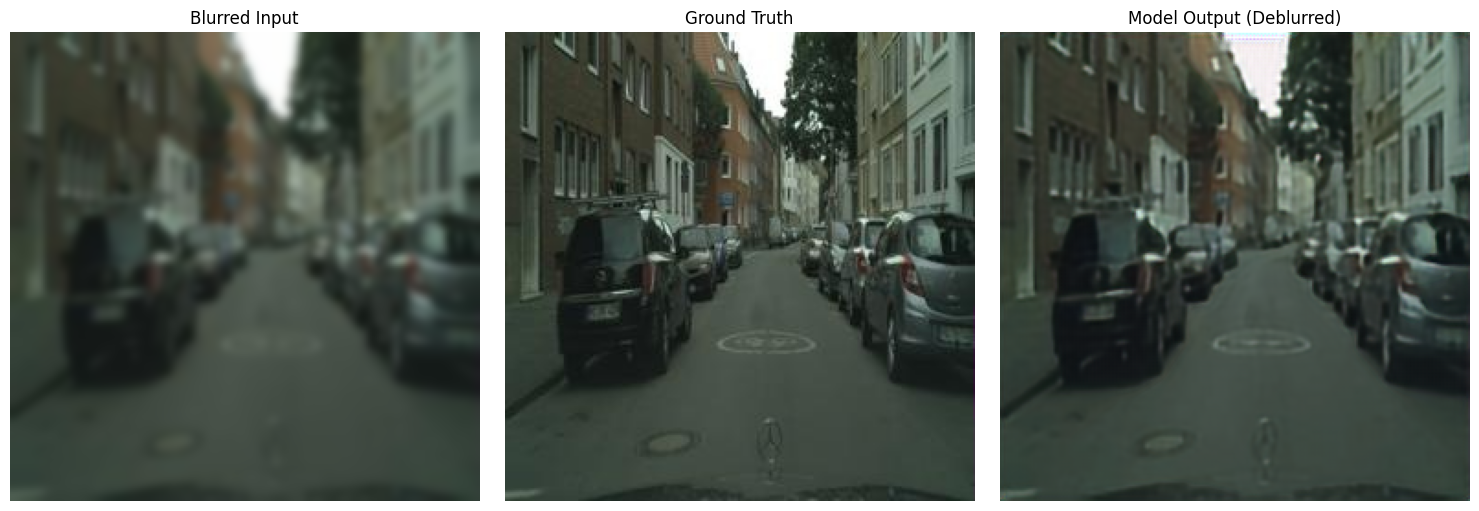

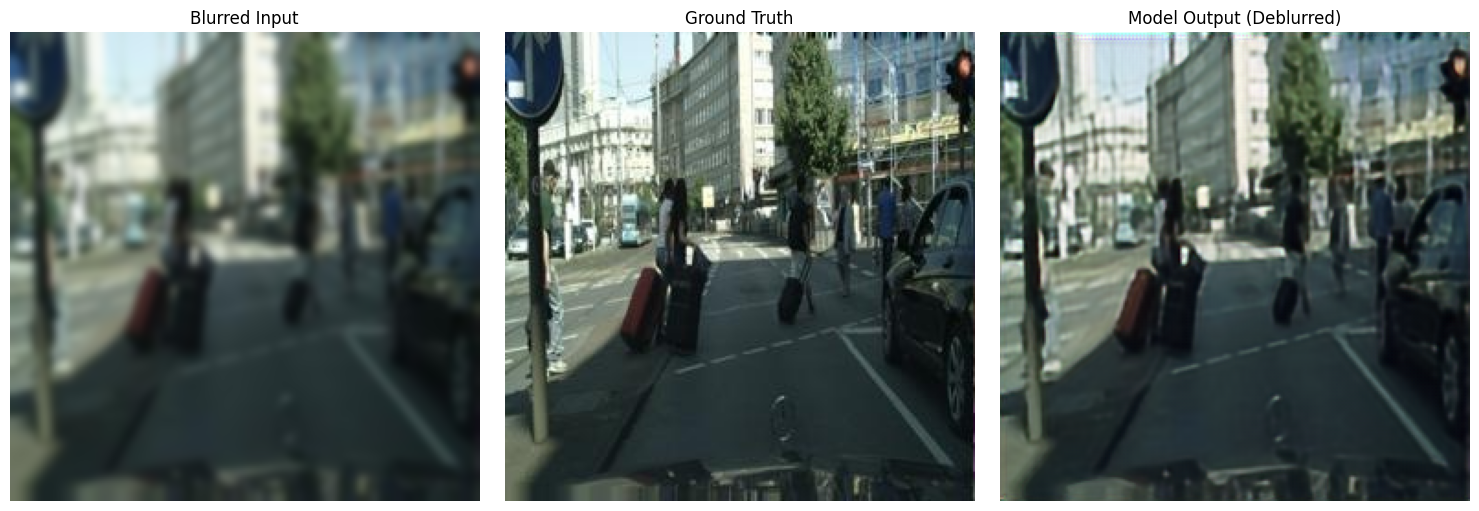

In [19]:
import os
import torch
import matplotlib.pyplot as plt

save_dir = "/kaggle/working/deblurred_outputs"
os.makedirs(save_dir, exist_ok=True)

deblur_model.eval()
with torch.no_grad():
    for batch_idx, (images, blurred_images) in enumerate(test_loader_blur):
        images = images.to(device)
        blurred_images = blurred_images.to(device)

        outputs = deblur_model(blurred_images)

        # Save all outputs to .pt files
        for i, output in enumerate(outputs):
            file_path = os.path.join(save_dir, f"deblurred_{batch_idx}_{i}.pt")
            torch.save(output.cpu(), file_path)
        if batch_idx == 0:
            images = images.cpu()
            blurred_images = blurred_images.cpu()
            outputs = outputs.cpu()

            for i in range(min(3, len(images))):
                blur_img = blurred_images[i].permute(1, 2, 0).numpy().clip(0, 1)
                true_img = images[i].permute(1, 2, 0).numpy().clip(0, 1)
                pred_img = outputs[i].permute(1, 2, 0).numpy().clip(0, 1)

                plt.figure(figsize=(15, 5))

                plt.subplot(1, 3, 1)
                plt.imshow(blur_img)
                plt.title("Blurred Input")
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.imshow(true_img)
                plt.title("Ground Truth")
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.imshow(pred_img)
                plt.title("Model Output (Deblurred)")
                plt.axis('off')

                plt.tight_layout()
                plt.show()


In [20]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from torchvision import models
from torchsummary import summary
from tqdm.notebook import tqdm

In [21]:
labels = [
    ['road', 'flat', [128, 64, 128]],
    ['sidewalk', 'flat', [244, 35, 232]],
    ['building', 'construction', [70, 70, 70]],
    ['wall', 'construction', [102, 102, 156]],
    ['fence', 'construction', [190, 153, 153]],
    ['pole', 'object', [153, 153, 153]],
    ['traffic light', 'object', [250, 170, 30]],
    ['traffic sign', 'object', [220, 220, 0]],
    ['vegetation', 'nature', [107, 142, 35]],
    ['terrain', 'nature', [152, 251, 152]],
    ['sky', 'sky', [70, 130, 180]],
    ['person', 'human', [220, 20, 60]],
    ['rider', 'human', [255, 0, 0]],
    ['car', 'vehicle', [0, 0, 142]],
    ['truck', 'vehicle', [0, 0, 70]],
    ['bus', 'vehicle', [0, 60, 100]],
    ['train', 'vehicle', [0, 80, 100]],
    ['motorcycle', 'vehicle', [0, 0, 230]],
    ['bicycle', 'vehicle', [119, 11, 32]],
]


id2color = {i: np.array(label[2]) for i, label in enumerate(labels)}
color2trainId = {tuple(label[2]): i for i, label in enumerate(labels)}


/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/1269.jpg


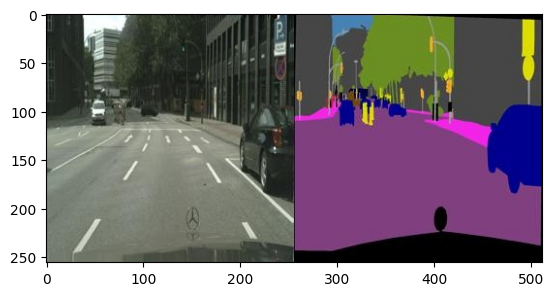

In [22]:
sample_image_show = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_show).convert("RGB")
plt.imshow(sample_image)
print(sample_image_show)

In [23]:
def find_closest_labels_vectorized(mask, color2trainId):
    closest_distance = np.full((mask.shape[0], mask.shape[1]), 1e6)
    closest_category = np.full((mask.shape[0], mask.shape[1]), 255)

    for color, trainId in color2trainId.items():
        color = np.array(color)
        dist = np.linalg.norm(mask - color.reshape((1, 1, 3)), axis=-1)
        is_closer = dist < closest_distance
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, trainId, closest_category)

    return closest_category

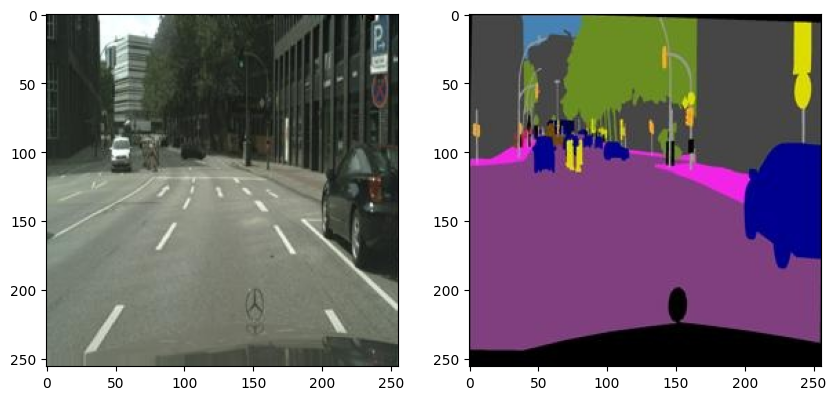

In [24]:
sample_image = np.array(sample_image)
cityscape, label = split_image(sample_image)

# display split images
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [25]:
IMAGE_SIZE = [256, 256]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

In [26]:
train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
# val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
train_images = [] 
train_masks = []
train_masks_enc = []
# val_images = []
# val_masks = []
# val_masks_enc = []

for train_file in tqdm(os.listdir(train_filepath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath + train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(find_closest_labels_vectorized(mask, color2trainId))
    
# for val_file in tqdm(os.listdir(val_filepath), desc = 'Building Validation Dataset: '):
#     image, mask = image_mask_split(val_filepath + val_file, IMAGE_SIZE)
#     val_images.append(image)
#     val_masks.append(mask)
#     val_masks_enc.append(find_closest_labels_vectorized(mask, color2trainId))

Building Training Dataset:   0%|          | 0/2975 [00:00<?, ?it/s]

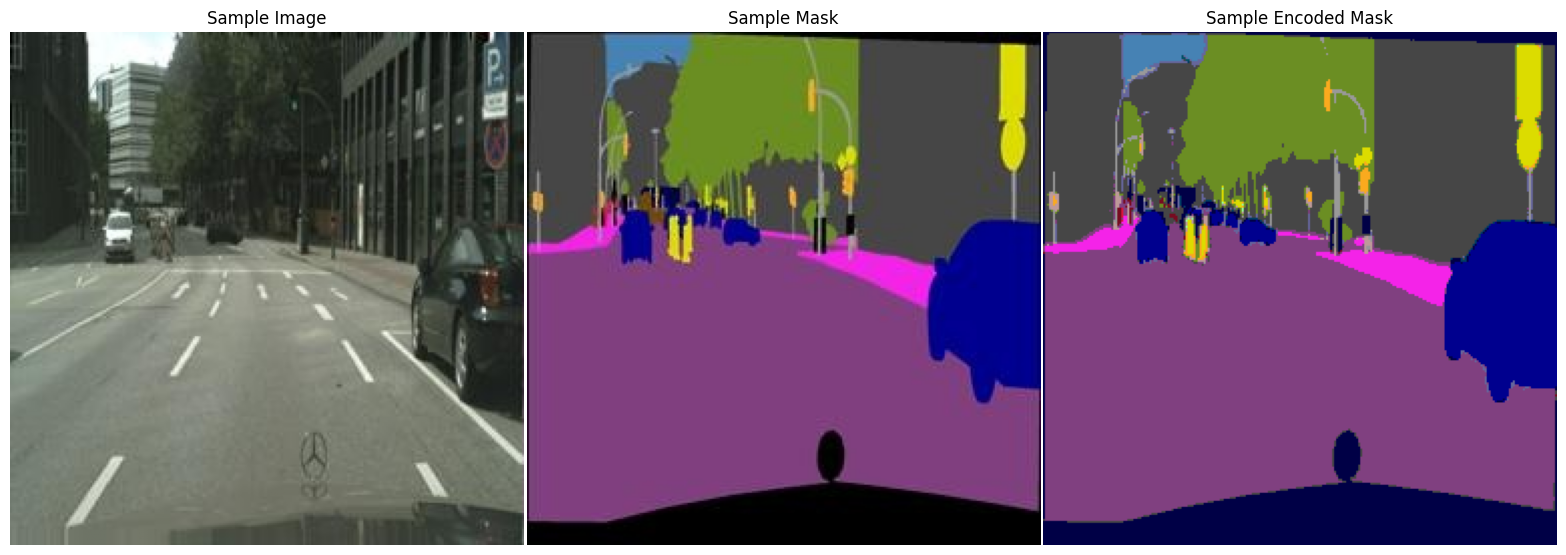

In [27]:
plt.figure(figsize=[20, 14])

for i in range(1):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]  # Should be shape [H, W], with trainIds (0–18)

    tmp = np.zeros([enc.shape[0], enc.shape[1], 3], dtype=np.uint8)

    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[int(enc[row, col])]

    plt.subplot(2, 3, i * 3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Image')

    plt.subplot(2, 3, i * 3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.title('Sample Mask')

    plt.subplot(2, 3, i * 3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.title('Sample Encoded Mask')

plt.subplots_adjust(wspace=0, hspace=0.1)


In [30]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

# val_images = np.stack(val_images).astype('float32')
# val_masks_enc = np.stack(val_masks_enc).astype('float32')

In [31]:
unique_vals = np.unique(train_masks_enc)
print("Unique mask labels:", unique_vals)

Unique mask labels: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18.]


In [44]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.se = SEBlock(out_channels) 

    def forward(self, x):
        x = self.conv(x)
        return self.se(x)

class Segmentation(nn.Module):
    def __init__(self, in_channels=3, out_channels=19, features=[64, 128, 256, 512]):
        super(Segmentation, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [45]:
class CustomTrainDataset(Dataset):
    def __init__(self, images, masks_enc, transform=None):
        self.images = images
        self.masks_enc = masks_enc
        self.transform = transform
        print(f"Total valid images: {len(self.images)}")
        print(f"total valid mask:{len(self.masks_enc)}")

    def __len__(self):
        return len(self.images)
        

    def __getitem__(self, idx):
        image = self.images[idx]
        mask_enc = self.masks_enc[idx]

       
        image = torch.tensor(image).permute(2, 0, 1).float()  
        mask_enc = torch.tensor(mask_enc).long()  

        if self.transform:
            image = self.transform(image)
            mask_enc = self.transform(mask_enc)

        return image, mask_enc



In [46]:
from torch.utils.data import DataLoader
train_dataset = CustomTrainDataset(train_images, train_masks_enc)
# val_dataset = CustomTrainDataset(val_images, val_masks_enc)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
for image,mask_enc in train_loader:
  print("Train batch-Clean images shape:",image.shape)
  print("Train batch-Mask shape:",mask_enc.shape)
  break
# for image, mask_enc in val_loader:
#   print("Val batch - Clean images shape:", image.shape)
#   print("Val batch - Mask shape:", mask_enc.shape)
#   break


Total valid images: 2975
total valid mask:2975
Train batch-Clean images shape: torch.Size([8, 3, 256, 256])
Train batch-Mask shape: torch.Size([8, 256, 256])


In [47]:
def sanitize_mask_labels(mask):
    # Torch tensors don't have .copy(), and we want to avoid modifying in-place
    mask = mask.clone()  # use .clone() for torch tensors
    mask[mask > 19] = 255
    return mask


In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Correct import

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seg_model = Segmentation(in_channels=3, out_channels=19).to(device)

lossc = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(seg_model.parameters(), lr=1e-4)

num_epochs = 50

for epoch in range(num_epochs):
    seg_model.train()
    running_loss = 0.0

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)

    for clean, mask in train_loader_tqdm:
        clean = clean.to(device)
        mask=sanitize_mask_labels(mask).to(device)

        optimizer.zero_grad()
        output = seg_model(clean)
        loss = lossc(output, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

 
    print(f"Epoch [{epoch+1}/{num_epochs}] ➤ Train Loss: {avg_train_loss:.4f} ")



Epoch [1/50]


Epoch [1/50] ➤ Train Loss: 1.9976 

Epoch [2/50]


Epoch [2/50] ➤ Train Loss: 1.2471 

Epoch [3/50]


Epoch [3/50] ➤ Train Loss: 0.9397 

Epoch [4/50]


Epoch [4/50] ➤ Train Loss: 0.8134 

Epoch [5/50]


Epoch [5/50] ➤ Train Loss: 0.7384 

Epoch [6/50]


Epoch [6/50] ➤ Train Loss: 0.6986 

Epoch [7/50]


Epoch [7/50] ➤ Train Loss: 0.6655 

Epoch [8/50]


Epoch [8/50] ➤ Train Loss: 0.6379 

Epoch [9/50]


Epoch [9/50] ➤ Train Loss: 0.6231 

Epoch [10/50]


Epoch [10/50] ➤ Train Loss: 0.6073 

Epoch [11/50]


Epoch [11/50] ➤ Train Loss: 0.5882 

Epoch [12/50]


Epoch [12/50] ➤ Train Loss: 0.5760 

Epoch [13/50]


Epoch [13/50] ➤ Train Loss: 0.5655 

Epoch [14/50]


Epoch [14/50] ➤ Train Loss: 0.5536 

Epoch [15/50]


Epoch [15/50] ➤ Train Loss: 0.5415 

Epoch [16/50]


Epoch [16/50] ➤ Train Loss: 0.5323 

Epoch [17/50]


Epoch [17/50] ➤ Train Loss: 0.5235 

Epoch [18/50]


Epoch [18/50] ➤ Train Loss: 0.5129 

Epoch [19/50]


Epoch [19/50] ➤ Train Loss: 0.5034 

Epoch [20/50]


Epoch [20/50] ➤ Train Loss: 0.4946 

Epoch [21/50]


Epoch [21/50] ➤ Train Loss: 0.4892 

Epoch [22/50]


Epoch [22/50] ➤ Train Loss: 0.4806 

Epoch [23/50]


Epoch [23/50] ➤ Train Loss: 0.4737 

Epoch [24/50]


Epoch [24/50] ➤ Train Loss: 0.4680 

Epoch [25/50]


Epoch [25/50] ➤ Train Loss: 0.4595 

Epoch [26/50]


Epoch [26/50] ➤ Train Loss: 0.4519 

Epoch [27/50]


Epoch [27/50] ➤ Train Loss: 0.4486 

Epoch [28/50]


Epoch [28/50] ➤ Train Loss: 0.4444 

Epoch [29/50]


Epoch [29/50] ➤ Train Loss: 0.4346 

Epoch [30/50]


Epoch [30/50] ➤ Train Loss: 0.4289 

Epoch [31/50]


KeyboardInterrupt: 

In [50]:
from torch.utils.data import Dataset
import os
import torch
class DeblurredImageDataset(Dataset):
    def __init__(self,folder_path,transform=None):
        self.folder_path=folder_path
        self.file_list=sorted([f for f in os.listdir(folder_path) if f.endswith(".pt")])
        self.transform=transform
        print(f"total deblurred images found:{len(self.file_list)}")
    def __len__(self):
        return len(self.file_list)
    def __getitem__(self,idx):
        file_path=os.path.join(self.folder_path,self.file_list[idx])
        image=torch.load(file_path)
        if self.transform:
            image=self.transform(image)
        return image



In [51]:
deblurred_dataset=DeblurredImageDataset("/kaggle/working/deblurred_outputs/")
deblurred_loader=DataLoader(deblurred_dataset,batch_size=8,shuffle=False)

total deblurred images found:500


/tmp/ipykernel_31/681609787.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image=torch.load(file_path)


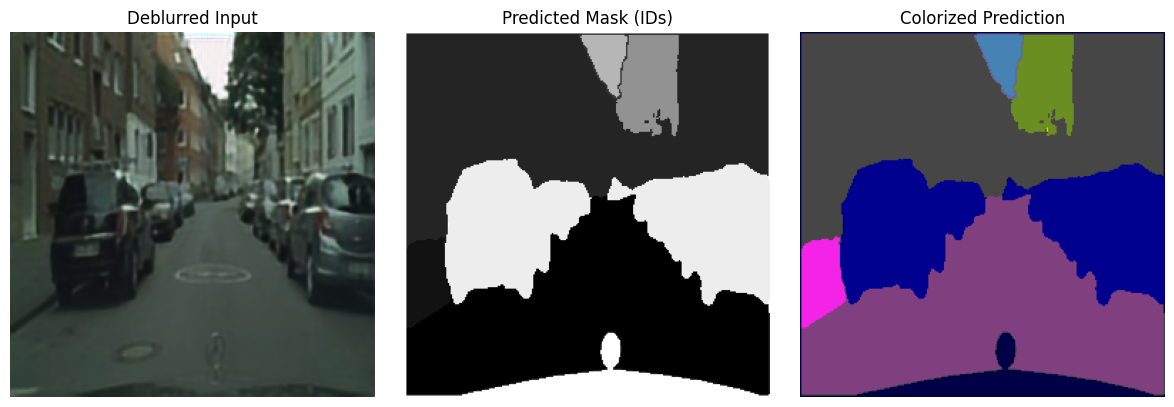

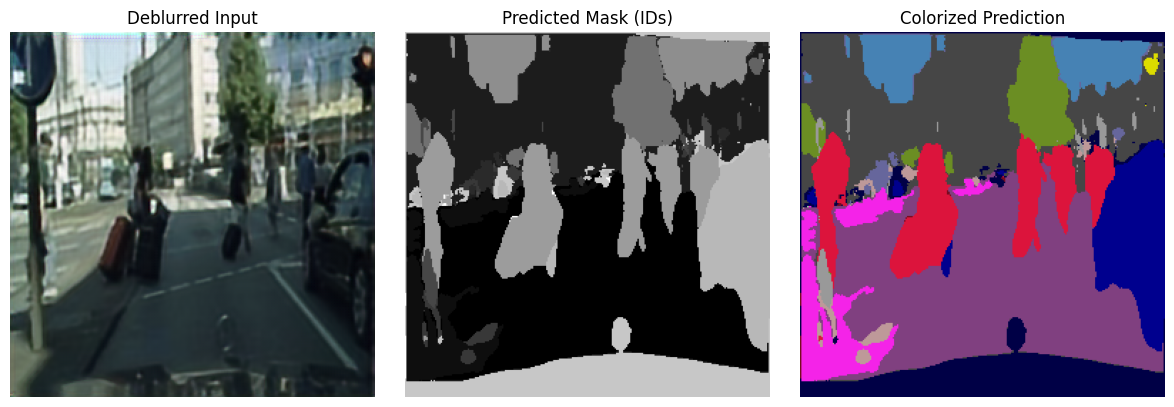

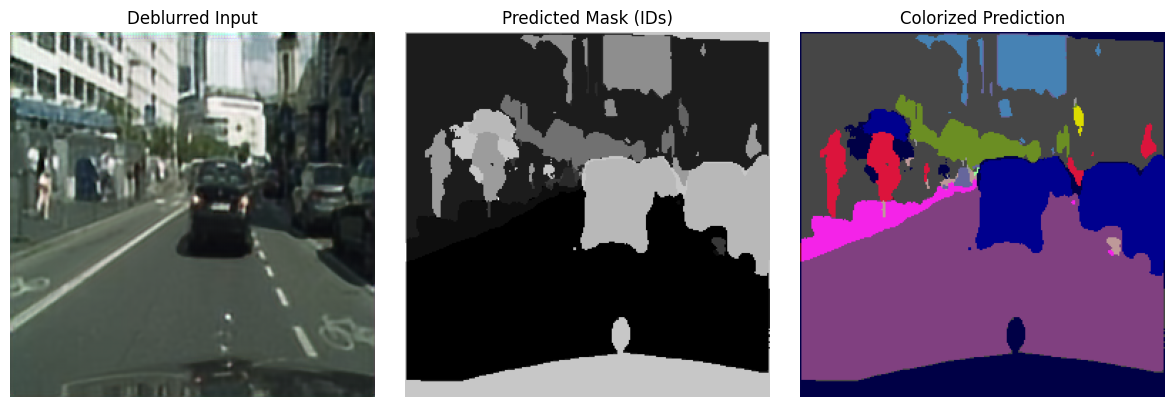

In [54]:
def decode_pred_mask(mask_tensor):
    mask_np = mask_tensor.cpu().numpy()
    h, w = mask_np.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for id, color in id2color.items():
        color_mask[mask_np == id] = color
    return color_mask

seg_model.eval()
with torch.no_grad():
    for image in deblurred_loader:
        image = image.to(device)
        outputs = seg_model(image)  # ✅ use 'image' here
        preds = torch.argmax(outputs, dim=1)

        for i in range(min(3, len(image))):
            input_img = image[i].cpu().permute(1, 2, 0).numpy().clip(0, 1)  # ✅ use 'image' here
            pred_mask = preds[i]
            color_mask = decode_pred_mask(pred_mask)

            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.imshow(input_img)
            plt.title("Deblurred Input")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(pred_mask.cpu(), cmap='gray')
            plt.title("Predicted Mask (IDs)")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(color_mask)
            plt.title("Colorized Prediction")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        break  # remove this line if you want to visualize the entire dataset
